# Zestaw zadań: Równania różniczkowe - spectral bias
## Zadanie 1
### Autor: Artur Gęsiarz

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Definicja analitycznego rozwiązania

In [36]:
def exact_solution(x, w):
    return (1/w) * torch.sin(w * x)

### Definicja sieci neuronowej

In [37]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh

        # warstwa poczatkowa
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # warstwa ukrytna
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])

        # warstwa wyjsciowa
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Funkcja obliczajca koszt warunku poczatkowego

In [38]:
def calculate_cond_start_cost(model, x_boundary):
    u0 = model(x_boundary)
    loss_ic = u0 ** 2
    return  loss_ic

### Funkcja obliczajca koszt rezydualny

In [39]:
def calculate_residual_cost(model, x_physics, w):
    u = model(x_physics)
    du_dx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    residual = du_dx - torch.cos(w * x_physics)
    loss_r = torch.mean(residual**2)
    return loss_r

### Funkcja obliczajca koszt totalny

In [40]:
def calculate_total_cost(model, x_boundary, x_physics, w):
    return calculate_cond_start_cost(model, x_boundary) + calculate_residual_cost(model, x_physics, w)

### Funkcja treningowa PINN

In [41]:
def train_PINN(model, x_boundary, x_physics, cost_fun, w, epochs=50000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for i in range(epochs):
        optimizer.zero_grad()

        loss = cost_fun(model, x_boundary, x_physics, w)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 5000 == 0:
            print(f'Epoch {i}, Loss: {loss.item()}')

    return model, losses

### Funkcja do rysowania wyników

In [42]:
def plot_results(x_test, u_exact, u_pred, losses, title):

    plt.plot(x_test, u_exact, label='Exact solution')
    plt.plot(x_test, u_pred, '--', label='PINN solution')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(title + ': Solution')
    plt.legend()
    plt.show()

    plt.plot(x_test, abs((u_exact - u_pred)))
    plt.xlabel('x')
    plt.ylabel('error')
    plt.title(title + ': Error function')
    plt.show()

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title + ': Training Loss')
    plt.show()

### Stałe w naszym modelu

In [43]:
N_INPUT = 1
N_OUTPUT = 1
LR = 0.001
EPOCHS = 50000

### a) Przypadek $ \omega = 1$

### Parametry naszego modelu

In [44]:
N_LAYERS = 2
N_HIDDEN = 16
TRAINING_POINTS = 200
TESTING_POINTS = 1000
OMEGA = 1

### Definicja modelu

In [45]:
model_a = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

### Definicja punktów treningowych i testowych

In [46]:
x_boundary_a = torch.tensor([[0.0]], requires_grad=True)
x_physics_a = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)
x_test_a = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_a = exact_solution(x_test_a, OMEGA)

### Trening modelu

In [47]:
print(f'Training for w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}\n')
model_a ,losses_a = train_PINN(model_a, x_boundary_a, x_physics_a, calculate_total_cost, OMEGA, EPOCHS, LR)

Training for w = 1, Layers = 2, Neurons = 16

Epoch 0, Loss: 0.5822675824165344
Epoch 5000, Loss: 1.4741795894224197e-05
Epoch 10000, Loss: 8.962233550846577e-06
Epoch 15000, Loss: 6.763334113202291e-06
Epoch 20000, Loss: 5.6227322602353524e-06
Epoch 25000, Loss: 4.731438821181655e-06
Epoch 30000, Loss: 4.304125468479469e-06
Epoch 35000, Loss: 1.838552998378873e-05
Epoch 40000, Loss: 4.393485141918063e-05
Epoch 45000, Loss: 2.570862307038624e-06


### Zapisywanie treningu do osobnego pliku

In [48]:
torch.save(model_a, "models/model_a_2_16.pth")

### Wczytywanie treningu z pliku

In [49]:
model_load_a = torch.load("models/model_a_2_16.pth")

### Przewidywanie wartości

In [50]:
u_pred_a = model_load_a(x_test_a).detach().numpy()
u_exact_a = u_exact_a.numpy()

### Rysowanie wynikow

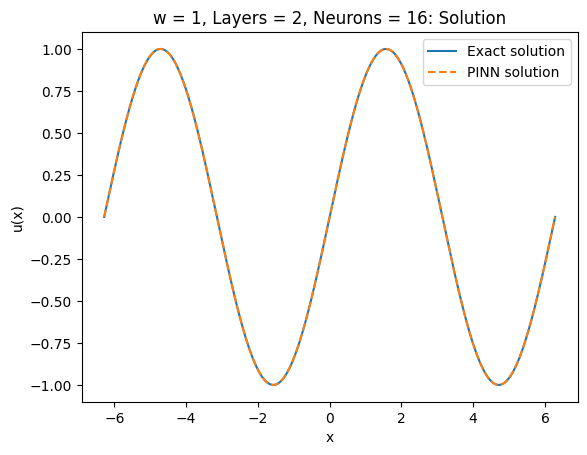

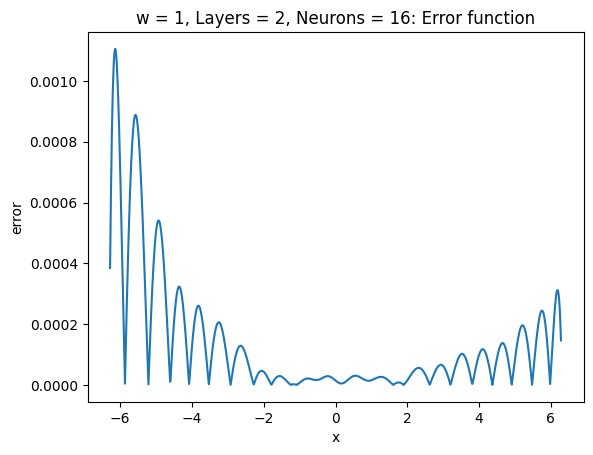

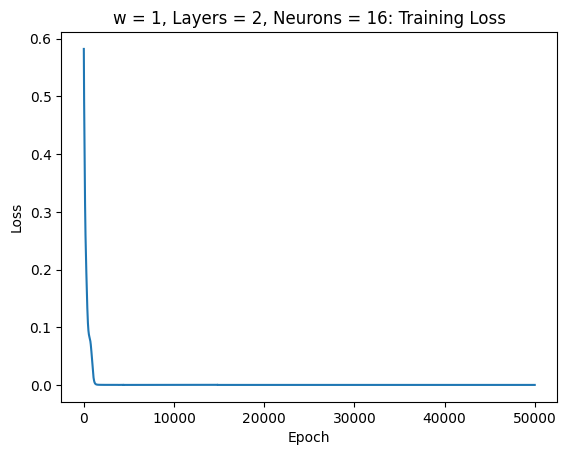

In [51]:
plot_results(x_test_a, u_exact_a, u_pred_a, losses_a, f'w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}')

### b) Przypadek $ \omega = 15$

### Parametry naszego modelu

In [52]:
TRAINING_POINTS = 3000
TESTING_POINTS = 5000
OMEGA = 15
ARCH = [(2,16), (4,64), (5,128)]

### Def. modelu, def. pkt. treningowych, def. pkt. testowych, trenig, przewidywanie wartosci, rysowanie...

Training for w = 15, Layers = 2, Neurons = 16

Epoch 0, Loss: 0.5059100389480591
Epoch 5000, Loss: 0.5001581907272339
Epoch 10000, Loss: 0.5001518130302429
Epoch 15000, Loss: 0.37171703577041626
Epoch 20000, Loss: 0.3354300558567047
Epoch 25000, Loss: 0.30359798669815063
Epoch 30000, Loss: 0.2871566116809845
Epoch 35000, Loss: 0.2758469879627228
Epoch 40000, Loss: 0.2698967158794403
Epoch 45000, Loss: 0.26349076628685


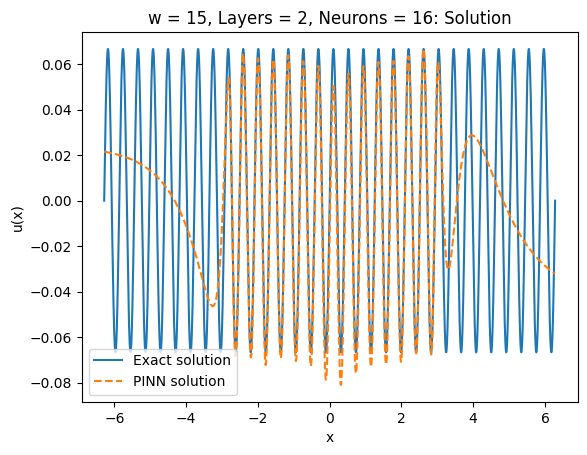

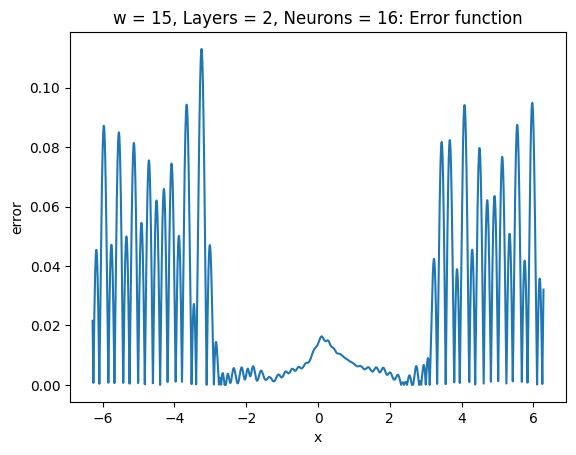

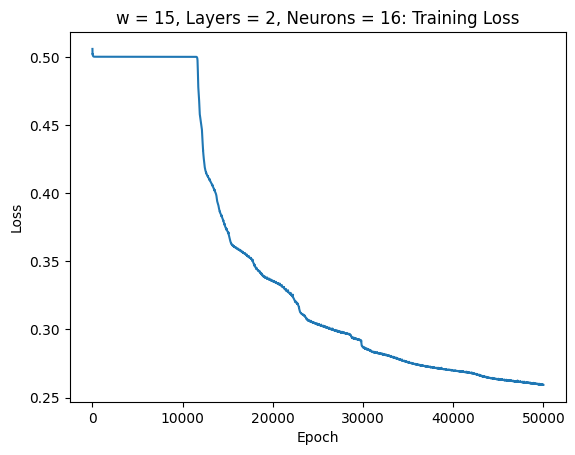

Training for w = 15, Layers = 4, Neurons = 64

Epoch 0, Loss: 0.5130742788314819
Epoch 5000, Loss: 0.5001604557037354
Epoch 10000, Loss: 0.500165581703186
Epoch 15000, Loss: 0.5001634955406189
Epoch 20000, Loss: 0.36732417345046997
Epoch 25000, Loss: 0.22944404184818268
Epoch 30000, Loss: 0.19761352241039276
Epoch 35000, Loss: 0.15260359644889832
Epoch 40000, Loss: 0.13662438094615936
Epoch 45000, Loss: 0.12664316594600677


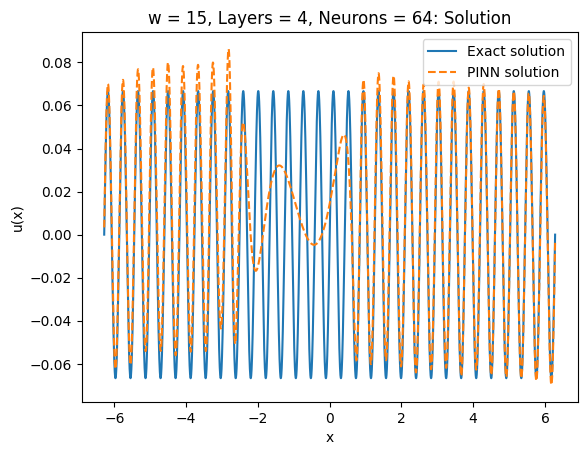

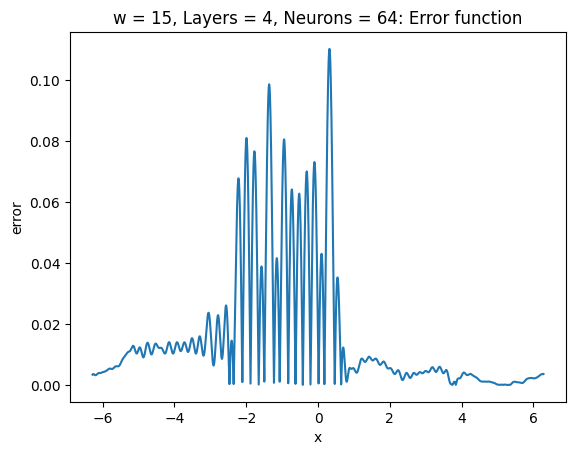

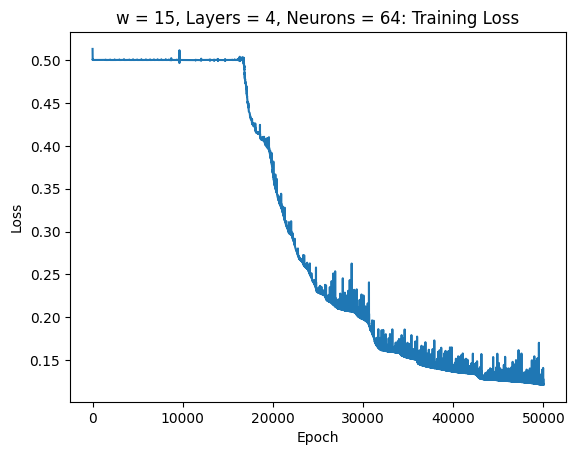

Training for w = 15, Layers = 5, Neurons = 128

Epoch 0, Loss: 0.5006354451179504
Epoch 5000, Loss: 0.5001646280288696
Epoch 10000, Loss: 0.5001631379127502
Epoch 15000, Loss: 0.5001654624938965
Epoch 20000, Loss: 0.5001668334007263
Epoch 25000, Loss: 0.5001627206802368
Epoch 30000, Loss: 0.5001693964004517
Epoch 35000, Loss: 0.31317567825317383
Epoch 40000, Loss: 0.01145904790610075
Epoch 45000, Loss: 0.0010360791347920895


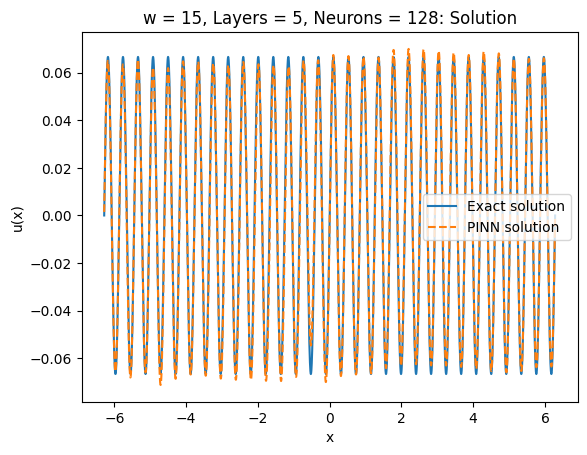

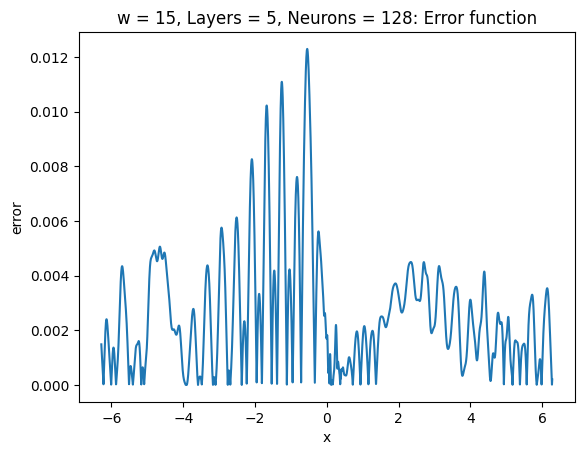

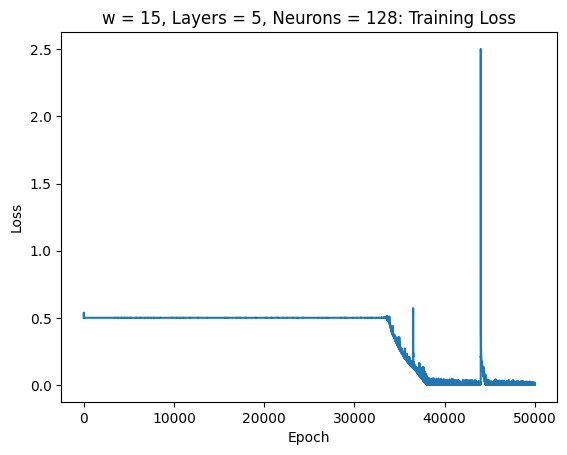

In [53]:
for N_LAYERS, N_HIDDEN in ARCH:

    # Definicja modelu
    model_b = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

    # Definicja punktów treningowych i testowych
    x_boundary_b = torch.tensor([[0.0]], requires_grad=True)
    x_physics_b = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)
    x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
    u_exact_b = exact_solution(x_test_b, OMEGA)

    # Trening
    print(f'Training for w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}\n')
    model_b, losses_b = train_PINN(model_b, x_boundary_b, x_physics_b, calculate_total_cost,OMEGA, EPOCHS, LR)

    # Zapis
    torch.save(model_b, f"models/model_b_{N_LAYERS}_{N_HIDDEN}.pth")

    # Odczyt
    model_load_b = torch.load(f"models/model_b_{N_LAYERS}_{N_HIDDEN}.pth")

    # Przewidywanie wartości
    u_pred_b = model_load_b(x_test_b).detach().numpy()
    u_exact_b = u_exact_b.numpy()

    # Rysowanie wykresow
    plot_results(x_test_b, u_exact_b, u_pred_b, losses_b, f'w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}')

### c) Dla wybranej sieci porównam wynik z rozwiązaniem w ktorym przyjeto inne rozwiazanie

### Funkcja obliczajca koszt totalny

In [54]:
def calculate_total_cost_anastaz(model, _, x_physics, w):
    u = torch.tanh(w * x_physics) * model(x_physics)
    u_x = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    loss_r = torch.mean(torch.pow((u_x - torch.cos(w * x_physics)),2))
    return loss_r

### Parametry naszego modelu

In [55]:
N_LAYERS = 5
N_HIDDEN = 128
TRAINING_POINTS = 3000
TESTING_POINTS = 5000
OMEGA = 15

### Definicja modelu

In [56]:
model_c = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

### Definicja punktów treningowych i testowych

In [57]:
x_physics_c = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)
x_test_c = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_c = exact_solution(x_test_c, OMEGA)

### Trening

In [58]:
print(f'ansatz - Training for w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}\n')
model_c, losses_c = train_PINN(model_c, _, x_physics_c, calculate_total_cost_anastaz, OMEGA, EPOCHS, LR)

ansatz - Training for w = 15, Layers = 5, Neurons = 128

Epoch 0, Loss: 0.49568143486976624
Epoch 5000, Loss: 0.2761479616165161
Epoch 10000, Loss: 0.07194691151380539
Epoch 15000, Loss: 0.005656463094055653
Epoch 20000, Loss: 0.009113319218158722
Epoch 25000, Loss: 0.003237822325900197
Epoch 30000, Loss: 0.0005882912664674222
Epoch 35000, Loss: 0.0009090893436223269
Epoch 40000, Loss: 0.005247323773801327
Epoch 45000, Loss: 0.006528172641992569


### Zapis

In [59]:
torch.save(model_c, f"models/model_c_{N_LAYERS}_{N_HIDDEN}.pth")

### Odczyt

In [60]:
model_c_load = torch.load(f"models/model_c_{N_LAYERS}_{N_HIDDEN}.pth")

### Przewidywanie wartości

In [61]:
u_pred_c = model_c_load(x_test_c).detach().numpy()
u_exact_c = u_exact_c.numpy()

### Rysowanie wykresow

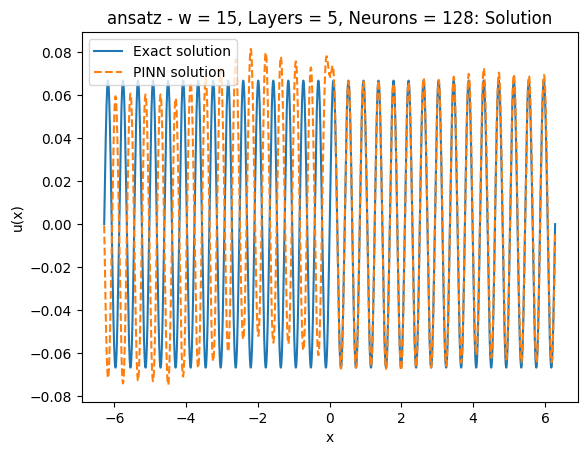

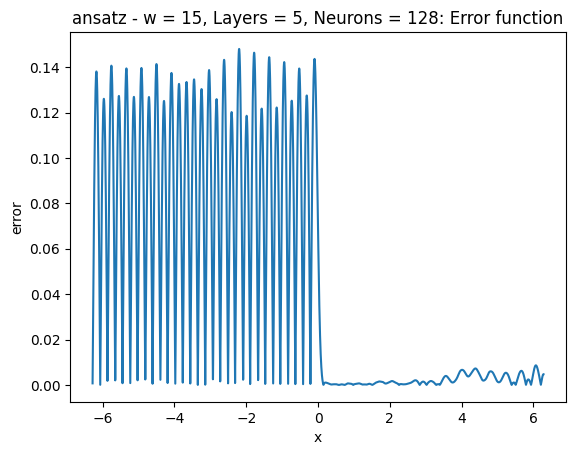

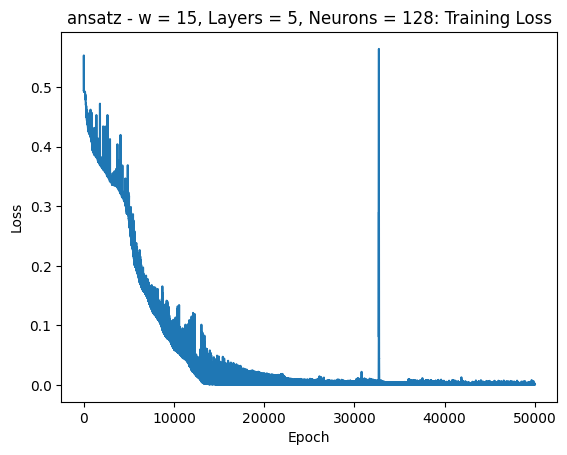

In [62]:
plot_results(x_test_c, u_exact_c, u_pred_c, losses_c, f'ansatz - w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}')

### d) Porównaj pierwotny wynik z rozwiązaniem, w którym pierwszą warstwę ukrytą zainicjalizowano cechami Fouriera

### Warstwa Fouriera

In [90]:
class FourierLayer(nn.Module):
    def __init__(self, N_INPUT, N_HIDDEN):
        super(FourierLayer, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        self.L = N_HIDDEN // 2
        self.linear = nn.Linear(2 * self.L, N_HIDDEN)

    def forward(self, x):
        # Tworzymy cechy Fouriera
        features = []
        for l in range(1, self.L + 1):
            features.append(torch.sin((2 ** l) * np.pi * x))
            features.append(torch.cos((2 ** l) * np.pi * x))
        features = torch.cat(features, dim=-1)
        return self.linear(features)

### Model Fouriera

In [91]:
class FourierFCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FourierFCN, self).__init__()

        self.fcs = FourierLayer(N_INPUT, N_HIDDEN)
        activation = nn.Tanh

        self.fch = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
            for _ in range(N_LAYERS - 1)
        ])

        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Paramtery naszego modelu

In [92]:
N_HIDDEN = 16
N_LAYERS = 2
TRAINING_POINTS = 3000
TESTING_POINTS = 5000
OMEGA = 15

### Definicja modelu

In [93]:
model_d = FourierFCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

### Definicja punktów treningowych i testowych

In [94]:
x_boundary_d = torch.tensor([[0.0]], requires_grad=True)
x_physics_d = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)
x_test_d = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_d = exact_solution(x_test_d, OMEGA)

### Trening

In [95]:
print(f'fourier - Training for w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}\n')
model_d, losses_d = train_PINN(model_d, x_boundary_d, x_physics_d, calculate_total_cost, OMEGA, EPOCHS, LR)

fourier - Training for w = 15, Layers = 2, Neurons = 16

Epoch 0, Loss: 2060.51123046875
Epoch 5000, Loss: 0.503797709941864
Epoch 10000, Loss: 0.4924986958503723
Epoch 15000, Loss: 0.34444254636764526
Epoch 20000, Loss: 0.3337084650993347
Epoch 25000, Loss: 0.32061707973480225
Epoch 30000, Loss: 0.32734084129333496
Epoch 35000, Loss: 0.31087878346443176
Epoch 40000, Loss: 0.30972006916999817
Epoch 45000, Loss: 0.30886954069137573


### Zapis

In [96]:
torch.save(model_d, f"models/model_d_{N_LAYERS}_{N_HIDDEN}.pth")

### Odczyt

In [97]:
model_d_load = torch.load(f"models/model_d_{N_LAYERS}_{N_HIDDEN}.pth")

### Przewidywanie wartości

In [98]:
u_pred_d = model_d_load(x_test_d).detach().numpy()
u_exact_d = u_exact_d.numpy()

### Rysowanie wykresow

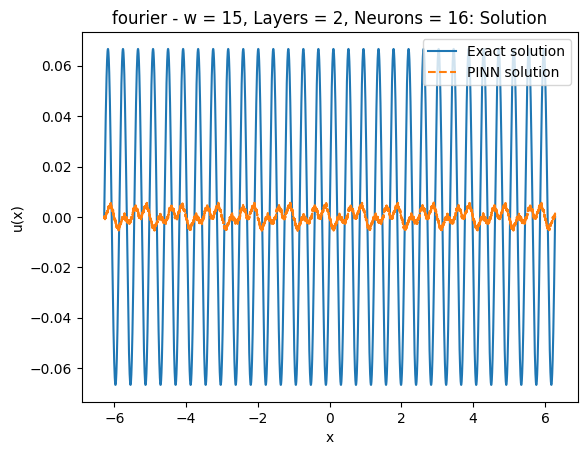

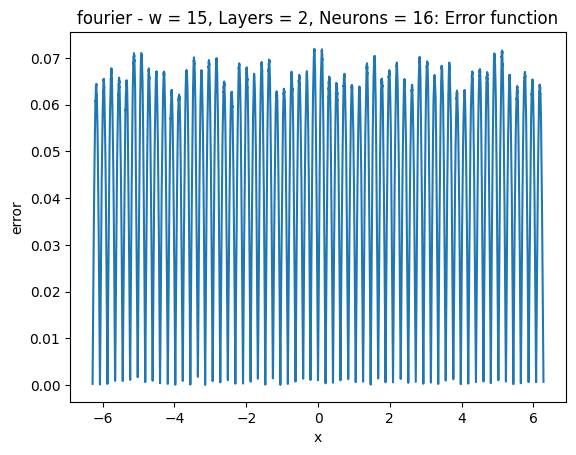

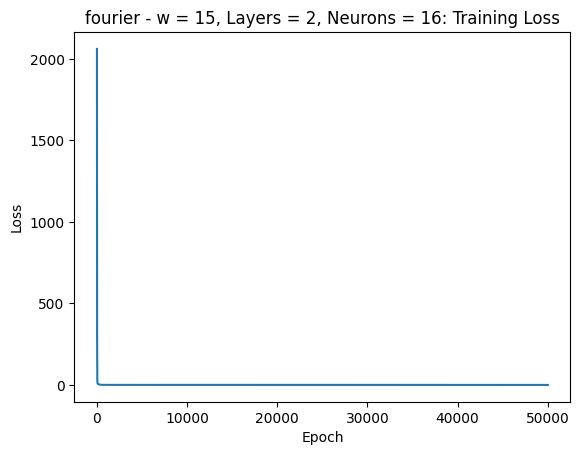

In [99]:
plot_results(x_test_d, u_exact_d, u_pred_d, losses_d, f'fourier - w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}')